# <center>Using SQLite for a data warehouse</center>

### Author:  Bryan Cafferky  - For Demonstration Purposes Only

### Not intended for production use. 

## Documentation at: https://docs.python.org/3/library/sqlite3.html

## Use SQLite Studio
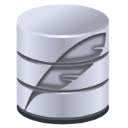

# Create or Point to Our SQLite database...

### 1)  Load the SQLite package...

In [1]:
import sqlite3

print(sqlite3.version)
print(sqlite3.sqlite_version)

import pandas as pd

/var/folders/tg/pz9klzrx2s1dps15b_lgvhqr0000gn/T/ipykernel_472/4291353319.py:3: DeprecationWarning: version is deprecated and will be removed in Python 3.14
  print(sqlite3.version)


2.6.0
3.50.1


## Danger!!! Danger!!! Will Robinson!  
## You Must have SQLite Version  3.24.0 (2018-06-04) or Higher

### 2) Connect to the database.  

In [2]:
conn = sqlite3.connect('aw.db') # permanent database

## Warning:  SQLite Data Maintenance Statements are very weak!!!

# Get Data from database management systems...

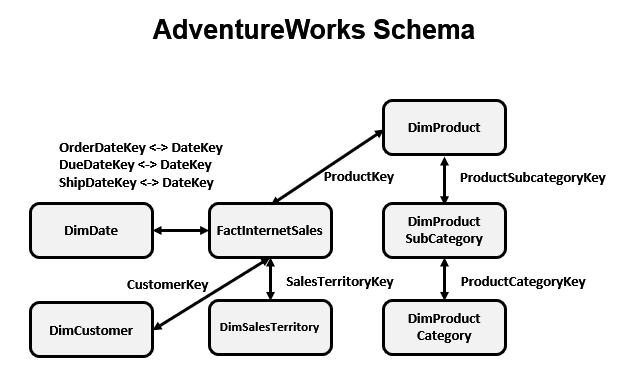

### We need to create the table with a primary key before saving data to it.
### The Primary Key uniquely identifies each row which we need so we can 
### tell SQLite which rows to Update or Delete.
### You cannot add a primary key to an existing table in SQLite!!!

In [4]:
conn.execute('DROP TABLE IF EXISTS customer')

In [5]:
conn.execute('''
CREATE TABLE customer (
    CustomerKey   INTEGER PRIMARY KEY NOT NULL,
    LastName      TEXT,
    BirthDate     TEXT,
    MaritalStatus TEXT,
    YearlyIncome  REAL,
    ModifiedDate  TEXT,
    ETLLastUpdate DATETIME DEFAULT current_timestamp 
);
''')

In [6]:
import pandas as pd

pd.read_sql_query("select name from sqlite_master where type = 'table'", conn)

,name
0,customer


### Load the master table...

In [7]:
custdf = pd.read_csv("data/dimcustomer.csv", index_col = False)

In [9]:
custdf

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ModifiedDate
0,11000,Yang,1971-10-06,M,90000.0,2019-01-01
1,11001,Huang,1976-05-10,S,60000.0,2019-01-01
2,11002,Torres,1971-02-09,M,60000.0,2019-01-01
3,11003,Zhu,1973-08-14,S,70000.0,2019-01-01


### Save the dataframe to a table...

## Warning!!! Do not use if_exists='replace' or you will lose the primary key.  
### The table gets dropped and created again!

In [10]:
custdf.to_sql('customer', conn, if_exists='append', index = False)

4

In [11]:
pd.read_sql_query("select * from customer", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ModifiedDate,ETLLastUpdate
0,11000,Yang,1971-10-06,M,90000.0,2019-01-01,2025-08-13 10:30:07
1,11001,Huang,1976-05-10,S,60000.0,2019-01-01,2025-08-13 10:30:07
2,11002,Torres,1971-02-09,M,60000.0,2019-01-01,2025-08-13 10:30:07
3,11003,Zhu,1973-08-14,S,70000.0,2019-01-01,2025-08-13 10:30:07


#### Getting meta data...

In [12]:
custdf.columns 

Index(['CustomerKey', 'LastName', 'BirthDate', 'MaritalStatus', 'YearlyIncome',
       'ModifiedDate'],
      dtype='object')

In [13]:
custdf.dtypes

CustomerKey        int64
LastName          object
BirthDate         object
MaritalStatus     object
YearlyIncome     float64
ModifiedDate      object
dtype: object

In [14]:
# Get table schema...
import pandas as pd 

pd.read_sql_query("""
PRAGMA table_info('customer');
""", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,CustomerKey,INTEGER,1,None,1
1,1,LastName,TEXT,0,None,0
2,2,BirthDate,TEXT,0,None,0
3,3,MaritalStatus,TEXT,0,None,0
4,4,YearlyIncome,REAL,0,None,0
5,5,ModifiedDate,TEXT,0,None,0
6,6,ETLLastUpdate,DATETIME,0,current_timestamp,0


## Inserting, Updating, and Deleting the old fashioned way...

### Insert

In [15]:
sql = '''
INSERT INTO customer (CustomerKey, LastName, BirthDate, MaritalStatus, YearlyIncome, ModifiedDate)
VALUES (999901, 'Zach', '2001-02-01', 'S', 32000, '2020-03-01')
'''
conn.execute(sql)

In [16]:
pd.read_sql_query("select * from customer", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ModifiedDate,ETLLastUpdate
0,11000,Yang,1971-10-06,M,90000.0,2019-01-01,2025-08-13 10:30:07
1,11001,Huang,1976-05-10,S,60000.0,2019-01-01,2025-08-13 10:30:07
2,11002,Torres,1971-02-09,M,60000.0,2019-01-01,2025-08-13 10:30:07
3,11003,Zhu,1973-08-14,S,70000.0,2019-01-01,2025-08-13 10:30:07
4,999901,Zach,2001-02-01,S,32000.0,2020-03-01,2025-08-13 10:32:09


### Update

In [17]:
conn.execute('''UPDATE customer 
                 SET LastName = 'Jones', MaritalStatus = 'M' 
                WHERE CustomerKey = 11001''')

pd.read_sql_query("select * from customer", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ModifiedDate,ETLLastUpdate
0,11000,Yang,1971-10-06,M,90000.0,2019-01-01,2025-08-13 10:30:07
1,11001,Jones,1976-05-10,M,60000.0,2019-01-01,2025-08-13 10:30:07
2,11002,Torres,1971-02-09,M,60000.0,2019-01-01,2025-08-13 10:30:07
3,11003,Zhu,1973-08-14,S,70000.0,2019-01-01,2025-08-13 10:30:07
4,999901,Zach,2001-02-01,S,32000.0,2020-03-01,2025-08-13 10:32:09


### Delete

In [18]:
conn.execute("DELETE FROM customer where CustomerKey = 999901")
pd.read_sql_query("select * from customer", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ModifiedDate,ETLLastUpdate
0,11000,Yang,1971-10-06,M,90000.0,2019-01-01,2025-08-13 10:30:07
1,11001,Jones,1976-05-10,M,60000.0,2019-01-01,2025-08-13 10:30:07
2,11002,Torres,1971-02-09,M,60000.0,2019-01-01,2025-08-13 10:30:07
3,11003,Zhu,1973-08-14,S,70000.0,2019-01-01,2025-08-13 10:30:07


## Let's do this in a realistic way...

### Lets load the transaction file...

In [20]:
# transaction carry information about the action taken on the row
# u = update, a = add, d = delete
transdf = pd.read_csv("data/dimcustomertransactions.csv", index_col = None)
transdf

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ActionInd,ModifiedDate
0,11000,Yang,1971-10-06,M,250000.0,U,2020-01-01
1,11001,Jones,1976-05-10,S,360000.0,U,2019-02-01
2,333301,Murhpy,1975-02-09,M,33000.0,A,2018-01-01
3,333302,Jain,1980-01-09,M,28000.0,A,2020-02-01
4,11002,Torres,1971-02-09,M,60000.0,D,2020-02-01


In [21]:
transdf.to_sql('cust_trans', conn, if_exists='replace', index = False)
pd.read_sql_query("select * from cust_trans", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ActionInd,ModifiedDate
0,11000,Yang,1971-10-06,M,250000.0,U,2020-01-01
1,11001,Jones,1976-05-10,S,360000.0,U,2019-02-01
2,333301,Murhpy,1975-02-09,M,33000.0,A,2018-01-01
3,333302,Jain,1980-01-09,M,28000.0,A,2020-02-01
4,11002,Torres,1971-02-09,M,60000.0,D,2020-02-01


In [23]:
#  Get the customer data back to the start position...
conn.execute('DELETE FROM customer')
custdf.to_sql('customer', conn, if_exists='append', index = False)
pd.read_sql_query("select * from customer", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ModifiedDate,ETLLastUpdate
0,11000,Yang,1971-10-06,M,90000.0,2019-01-01,2025-08-13 10:36:43
1,11001,Huang,1976-05-10,S,60000.0,2019-01-01,2025-08-13 10:36:43
2,11002,Torres,1971-02-09,M,60000.0,2019-01-01,2025-08-13 10:36:43
3,11003,Zhu,1973-08-14,S,70000.0,2019-01-01,2025-08-13 10:36:43


In [24]:
pd.read_sql_query("select * from cust_trans", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ActionInd,ModifiedDate
0,11000,Yang,1971-10-06,M,250000.0,U,2020-01-01
1,11001,Jones,1976-05-10,S,360000.0,U,2019-02-01
2,333301,Murhpy,1975-02-09,M,33000.0,A,2018-01-01
3,333302,Jain,1980-01-09,M,28000.0,A,2020-02-01
4,11002,Torres,1971-02-09,M,60000.0,D,2020-02-01


### Let's update the customer table with the transactions.
- Add    - If the customer is not found, insert transaction as new customer.
- Change - If the customer is found, update the existing customer with the transaction data.
- Delete - If the DropInd = 'Y', remove the customer row. 

#### Note:  You must supply column names to allow the ETLLastUpdate to Default...

In [25]:
# Insert
conn.execute('''INSERT INTO customer 
                   (CustomerKey, LastName, BirthDate, MaritalStatus, YearlyIncome, ModifiedDate)     
                SELECT CustomerKey, LastName, BirthDate, MaritalStatus, YearlyIncome, ModifiedDate 
                FROM cust_trans 
                where ActionInd = 'A';''')

pd.read_sql_query("select * from customer", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ModifiedDate,ETLLastUpdate
0,11000,Yang,1971-10-06,M,90000.0,2019-01-01,2025-08-13 10:36:43
1,11001,Huang,1976-05-10,S,60000.0,2019-01-01,2025-08-13 10:36:43
2,11002,Torres,1971-02-09,M,60000.0,2019-01-01,2025-08-13 10:36:43
3,11003,Zhu,1973-08-14,S,70000.0,2019-01-01,2025-08-13 10:36:43
4,333301,Murhpy,1975-02-09,M,33000.0,2018-01-01,2025-08-13 10:38:25
5,333302,Jain,1980-01-09,M,28000.0,2020-02-01,2025-08-13 10:38:25


###  SQLite Update statement is virtually useless!!!
 Example of doing an Update from another table from https://www.w3resource.com/sqlite/sqlite-update.php

In [ ]:
#  This example is to show the syntax only.  It cannot be executed.

UPDATE orders 
   SET   item_name=(
            SELECT prod_mast.prod_name 
            FROM prod_mast 
            WHERE orders.item_id=prod_mast.prod_id), 
         cost=(
            SELECT prod_mast.prod_rate*orders.ord_qty 
            FROM prod_mast 
            WHERE orders.item_id=prod_mast.prod_id);

In [26]:
pd.read_sql_query("select * from cust_trans where ActionInd = 'U'", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ActionInd,ModifiedDate
0,11000,Yang,1971-10-06,M,250000.0,U,2020-01-01
1,11001,Jones,1976-05-10,S,360000.0,U,2019-02-01


#### We'll Use REPLACE instead of Update but remember, this command deletes and re-inserts the row!!!

In [27]:
# Replace 
conn.execute('''
             INSERT OR REPLACE INTO customer 
                (CustomerKey, LastName, BirthDate, MaritalStatus, YearlyIncome, ModifiedDate)     
             SELECT CustomerKey, LastName, BirthDate, MaritalStatus, YearlyIncome, ModifiedDate 
             FROM cust_trans where ActionInd = 'U';''')

pd.read_sql_query("select * from customer", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ModifiedDate,ETLLastUpdate
0,11000,Yang,1971-10-06,M,250000.0,2020-01-01,2025-08-13 10:41:12
1,11001,Jones,1976-05-10,S,360000.0,2019-02-01,2025-08-13 10:41:12
2,11002,Torres,1971-02-09,M,60000.0,2019-01-01,2025-08-13 10:36:43
3,11003,Zhu,1973-08-14,S,70000.0,2019-01-01,2025-08-13 10:36:43
4,333301,Murhpy,1975-02-09,M,33000.0,2018-01-01,2025-08-13 10:38:25
5,333302,Jain,1980-01-09,M,28000.0,2020-02-01,2025-08-13 10:38:25


### Delete does not support joining to other tables...

In [28]:
pd.read_sql_query("select * from cust_trans where ActionInd = 'D'", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ActionInd,ModifiedDate
0,11002,Torres,1971-02-09,M,60000.0,D,2020-02-01


In [29]:
# Delete
conn.execute('''DELETE FROM customer  
                WHERE CustomerKey IN (
                SELECT CustomerKey 
                FROM cust_trans where ActionInd = 'D');''')

pd.read_sql_query("select * from customer", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ModifiedDate,ETLLastUpdate
0,11000,Yang,1971-10-06,M,250000.0,2020-01-01,2025-08-13 10:41:12
1,11001,Jones,1976-05-10,S,360000.0,2019-02-01,2025-08-13 10:41:12
2,11003,Zhu,1973-08-14,S,70000.0,2019-01-01,2025-08-13 10:36:43
3,333301,Murhpy,1975-02-09,M,33000.0,2018-01-01,2025-08-13 10:38:25
4,333302,Jain,1980-01-09,M,28000.0,2020-02-01,2025-08-13 10:38:25


In [31]:
#  Get the customer data back to the start position...
conn.execute('DELETE FROM customer')
custdf.to_sql('customer', conn, if_exists='append', index = False)
pd.read_sql_query("select * from customer", conn)

,CustomerKey,LastName,BirthDate,MaritalStatus,YearlyIncome,ModifiedDate,ETLLastUpdate
0,11000,Yang,1971-10-06,M,90000.0,2019-01-01,2025-08-13 10:43:05
1,11001,Huang,1976-05-10,S,60000.0,2019-01-01,2025-08-13 10:43:05
2,11002,Torres,1971-02-09,M,60000.0,2019-01-01,2025-08-13 10:43:05
3,11003,Zhu,1973-08-14,S,70000.0,2019-01-01,2025-08-13 10:43:05


_____

# Let's close the connection. 

In [32]:
conn.close()

# End Of Part 1